# Twitter & Lexis-Nexis 

#### Date: 07-12-2021

#### Developer: Yogesh
 
1. data sources used: Lexis Nexis, Twitter, coinmarketcap
2. Feature Extraction using BERT
3. Prediction of BTC prize using RF and XGBoost

### Content of this notebook:
1. Selected 10 twitter accounts to scrap from
2. Get tweets
3. Preprocess text data
4. Twitter Sentiment computation 
5. Combine Tweeter data and closing value from coinmarketcap data
6. Twitter data analysis
7. Apply XGBoost on forcasting
8. BERT on Twitter data then forecasting
9. Preprocessing of LexisNexis data and then applying BERT and XGBoost for the forcasting

In [1]:
from IPython.display import clear_output
from pandas import read_csv, DataFrame, to_datetime, merge
import snscrape.modules.twitter as sntwitter
import numpy as np

In [2]:
# If not installed please install the following:
#!pip install snscrape

#### Bitcoin Twitter data from specific credible Accounts (Working)

Top 10 bitcoin price twitter accounts

Source: https://coinme.com/10-crypto-twitter-accounts-everyone-should-follow/

lstUserNames = ['DocumentingBTC', 'APompliano', 'NickSzabo4', 'nic__carter','CarpeNoctom', 'Gladstein', '100trillionUSD',\
                'MessariCrypto', 'MartyBent', 'aantonop', \
                'APompliano','MessariCrypto','_Checkmatey_','coryklippsten','notsofast'] 


In [3]:
def get_tweeter_data(lstUserNames, strStartDate, strEndDate):
    
    tweets_list1 = []
    
    for n, k in enumerate(lstUserNames):
        clear_output()
        print(lstUserNames[n])
        
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f'bitcoin since:{strStartDate} until:{strEndDate} from:{lstUserNames[n]}').get_items()):
            
            #print(tweet) # Tweeter link
            #print(i, tweet.content) # Tweeter content
            
            # Tweets to save Per day limit is 10
            #print("{}'th iterations, Tweets collected {}, date reached: {} ".format(i,len(tweets_list1),tweet.date))
            
            #if len(tweets_list1)!=0 and len(tweets_list1)%1000 == 0:    tweets_list1.append('1')
                
            #print("{}'th iteration, Tweets collected {}, date reached: {} ".format(i,len(tweets_list1),tweet.date))
            tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.username])
        
         #for i,tweet in enumerate(sntwitter.TwitterSearchScraper(f' since:{strStartDate} until:{strEndDate}').get_items()):
         #   if len(tweets_list1)!=0 and len(tweets_list1)%1000 == 0:    tweets_list1.append('1')
         #   tweets_list1.append([tweet.date, tweet.id, tweet.content, tweet.username])
            
                
        print("Total Twitts:", len(tweets_list1))

    tweets_df2 = DataFrame(tweets_list1, columns=['datetime', 'tweet_id', 'text', 'username'])    
    return tweets_df2

In [4]:
# Top 10 bitcoin price twitter accounts
#Source: https://coinme.com/10-crypto-twitter-accounts-everyone-should-follow/
lstUserNames = ['DocumentingBTC', 'APompliano', 'NickSzabo4', 'nic__carter','CarpeNoctom', 'Gladstein', '100trillionUSD',\
                'MessariCrypto', 'MartyBent', 'aantonop', \
                'APompliano','MessariCrypto','_Checkmatey_','coryklippsten','notsofast'] 
#lstUserNames = ['DocumentingBTC', 'APompliano', 'NickSzabo4'] 

#lstAllCombined = keywords + lstUsersName
strBitCoinToSearch='bitcoin'
strStartDate="2021-06-25"
strEndDate="2021-10-26"
%time pdInputData=get_tweeter_data(lstUserNames, strStartDate, strEndDate)

notsofast
Total Twitts: 4834
Wall time: 1min 11s


In [5]:
#pdInputData=read_csv("Twitter_Data_2020-10-26_to_2021-11-26.csv")

In [6]:
pdInputData.dtypes

datetime    datetime64[ns, UTC]
tweet_id                  int64
text                     object
username                 object
dtype: object

In [7]:
intTotalTwitts=len(pdInputData)
print(f"Data is from:{pdInputData.datetime.min()} to {pdInputData.datetime.max()}, total={intTotalTwitts}")

Data is from:2021-06-25 01:18:43+00:00 to 2021-10-25 23:14:31+00:00, total=4834


In [8]:
pdInputData.head()

,datetime,tweet_id,text,username
0,2021-10-05 14:59:05+00:00,1445403172705607683,Legendary investor Bill Miller says “we are at...,DocumentingBTC
1,2021-10-05 14:57:04+00:00,1445402664049815555,US Bank to launch #Bitcoin custody services.\n...,DocumentingBTC
2,2021-10-04 16:40:41+00:00,1445066353556197384,#Bitcoin is never down.\n\nhttps://t.co/5jLJsD...,DocumentingBTC
3,2021-10-04 15:09:26+00:00,1445043389666312195,#Bitcoin 101 on ABC7 news with @natbrunell\n\n...,DocumentingBTC
4,2021-10-04 14:17:15+00:00,1445030259527753740,#Bitcoin Lightning growth is going vertical. h...,DocumentingBTC


#### Filter 1: Removing all the tweets after 7 pm daily. The closing price scraped from coinmarketcap is daily at 8 pm. So the prediction of closing price from twitter data should be done before 8 pm 

In [9]:
pdInputData=pdInputData[pdInputData['datetime'].apply(lambda x: x.hour <= 19)].reset_index()[pdInputData.columns]

In [10]:
print(f"Dropped: {intTotalTwitts-len(pdInputData)}")

Dropped: 960


In [11]:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag

def preprocessDataset(train_text):
       
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',lower=True,split=" ")
        
    #stop word removal
    stop_words = set(stopwords.words('english'))
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
        
    #--Stemming--
    stemmer= PorterStemmer()

    stem_input=word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
        
    lemmatizer = WordNetLemmatizer()

    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)

    lem_input = word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    
    #Stemming and lemmatization are methods used by search engines and chatbots to analyze the meaning behind a word. 
    #Stemming uses the stem of the word, while lemmatization uses the context in which the word is being used. 
    #We'll later go into more detailed explanations and examples.  
    
    return lem_text

In [12]:
%time pdInputData['LemmatizedText'] = pdInputData['text'].apply(preprocessDataset)

Wall time: 38.5 s


In [14]:
# pip install textblob
!pip install textblob

In [15]:
from textblob import TextBlob

In [16]:
pdInputData.head()

,datetime,tweet_id,text,username,LemmatizedText
0,2021-10-05 14:59:05+00:00,1445403172705607683,Legendary investor Bill Miller says “we are at...,DocumentingBTC,legendari investor bill miller say “ we top fi...
1,2021-10-05 14:57:04+00:00,1445402664049815555,US Bank to launch #Bitcoin custody services.\n...,DocumentingBTC,u bank launch bitcoin custodi servic that ’ s ...
2,2021-10-04 16:40:41+00:00,1445066353556197384,#Bitcoin is never down.\n\nhttps://t.co/5jLJsD...,DocumentingBTC,bitcoin never http co jljsdmjmj
3,2021-10-04 15:09:26+00:00,1445043389666312195,#Bitcoin 101 on ABC7 news with @natbrunell\n\n...,DocumentingBTC,bitcoin abc news natbrunel http co vuissvyz
4,2021-10-04 14:17:15+00:00,1445030259527753740,#Bitcoin Lightning growth is going vertical. h...,DocumentingBTC,bitcoin lightn growth go vertic http co quaxmagp


In [17]:
# Get polarity score
#pdInputData['SentimentPolarity1'] = pdInputData['ProcessedText'].apply(lambda x: TextBlob(x).sentiment.polarity)
pdInputData['SentimentPolarity'] = pdInputData['LemmatizedText'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [18]:
#Create seperate Date column
pdInputData["Date"]=pdInputData.datetime.apply(lambda x: x.date())

In [19]:
pdInputData.dtypes

datetime             datetime64[ns, UTC]
tweet_id                           int64
text                              object
username                          object
LemmatizedText                    object
SentimentPolarity                float64
Date                              object
dtype: object

In [20]:
pdInputData["Date"]=to_datetime(pdInputData.Date)

### Creating new daily avg sentiments

In [21]:
pdDailyAvgSentiments=pdInputData.groupby('Date')[['SentimentPolarity']].mean().reset_index()

In [22]:
pdDailyAvgSentiments.head()

,Date,SentimentPolarity
0,2021-06-25,0.102539
1,2021-06-26,-0.036828
2,2021-06-27,0.088709
3,2021-06-28,0.023519
4,2021-06-29,0.037699


In [23]:
pdDailyAvgSentiments.Date.min()

Timestamp('2021-06-25 00:00:00')

In [24]:
pdDailyAvgSentiments.Date.max()

Timestamp('2021-10-25 00:00:00')

In [25]:
pdDailyAvgSentiments['MinSentiment']=pdInputData.groupby('Date')[['SentimentPolarity']].min().reset_index()['SentimentPolarity']
pdDailyAvgSentiments['MaxSentiment']=pdInputData.groupby('Date')[['SentimentPolarity']].max().reset_index()['SentimentPolarity']

In [26]:
pdDailyAvgSentiments['TweetVolume']=pdInputData.groupby('Date')[['tweet_id']].count().reset_index()['tweet_id']

In [27]:
pdDailyAvgSentiments.head()

,Date,SentimentPolarity,MinSentiment,MaxSentiment,TweetVolume
0,2021-06-25,0.102539,-0.275000,0.433333,43
1,2021-06-26,-0.036828,-0.800000,0.533333,24
2,2021-06-27,0.088709,-0.516667,0.400000,30
3,2021-06-28,0.023519,-0.700000,0.595238,55
4,2021-06-29,0.037699,-0.687500,0.800000,31


In [28]:
len(pdDailyAvgSentiments)

123

# Getting Closing price of BTC from coinmarketcap scraped data

In [29]:
pdCoinMarketData = read_csv("bitcoin_data.csv")
pdCoinMarketData.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,"Oct 24, 2021","61,368.34","61,505.80","59,643.35","60,930.84","27,316,183,882","1,148,743,134,468"
1,"Oct 23, 2021","60,694.63","61,743.88","59,826.52","61,393.62","26,882,546,034","1,157,410,091,263"
2,"Oct 22, 2021","62,237.89","63,715.02","60,122.80","60,692.26","38,434,082,775","1,144,131,483,274"
3,"Oct 21, 2021","66,002.23","66,600.55","62,117.41","62,210.17","45,908,121,370","1,172,684,282,558"
4,"Oct 20, 2021","64,284.59","66,930.39","63,610.67","65,992.84","40,788,955,582","1,243,927,428,207"


In [30]:
pdCoinMarketData.rename(columns={'Close**':'closeValue'}, inplace=True)

In [31]:
pdCoinMarketData.dtypes

Date          object
Open*         object
High          object
Low           object
closeValue    object
Volume        object
Market Cap    object
dtype: object

In [32]:
pdCoinMarketData['Date'] = to_datetime(pdCoinMarketData.Date)
pdCoinMarketData.head()

,Date,Open*,High,Low,closeValue,Volume,Market Cap
0,2021-10-24,"61,368.34","61,505.80","59,643.35","60,930.84","27,316,183,882","1,148,743,134,468"
1,2021-10-23,"60,694.63","61,743.88","59,826.52","61,393.62","26,882,546,034","1,157,410,091,263"
2,2021-10-22,"62,237.89","63,715.02","60,122.80","60,692.26","38,434,082,775","1,144,131,483,274"
3,2021-10-21,"66,002.23","66,600.55","62,117.41","62,210.17","45,908,121,370","1,172,684,282,558"
4,2021-10-20,"64,284.59","66,930.39","63,610.67","65,992.84","40,788,955,582","1,243,927,428,207"


In [33]:
pdCoinMarketData=pdCoinMarketData[pdCoinMarketData.Date >= pdDailyAvgSentiments.Date.min()]
pdCoinMarketData=pdCoinMarketData[pdCoinMarketData.Date <= pdDailyAvgSentiments.Date.max()]

# Keep latest twitter data upto dates to which we have coinmarket data with us
pdInputData=pdInputData[pdInputData.Date <= pdCoinMarketData.Date.max()]

print(f"Twitter Data is from:{pdInputData.Date.min()} to {pdInputData.Date.max()}, total={intTotalTwitts}")
print(f"CoinMarket Data is from:{pdCoinMarketData.Date.min()} to {pdCoinMarketData.Date.max()}, total={intTotalTwitts}")

Twitter Data is from:2021-06-25 00:00:00 to 2021-10-24 00:00:00, total=4834
CoinMarket Data is from:2021-06-25 00:00:00 to 2021-10-24 00:00:00, total=4834


In [34]:
pdCoinMarketData.dtypes

Date          datetime64[ns]
Open*                 object
High                  object
Low                   object
closeValue            object
Volume                object
Market Cap            object
dtype: object

In [35]:
pdCoinMarketData['closeValue'] = pdCoinMarketData['closeValue'].str.replace(',', '').astype(float)

<AxesSubplot:title={'center':'Tweeter Volume from Selected twitter accoint for BTC'}, xlabel='datetime'>

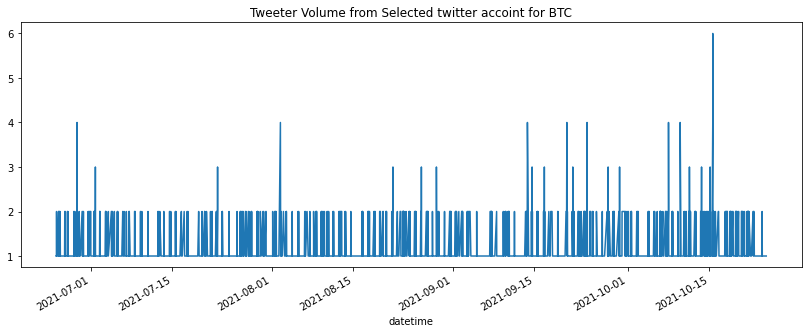

In [36]:
pdInputData.groupby('datetime').count()['tweet_id'].plot(figsize=(14, 5), title='Tweeter Volume from Selected twitter accoint for BTC')

<AxesSubplot:title={'center':'Twitter Sentiment'}, xlabel='datetime'>

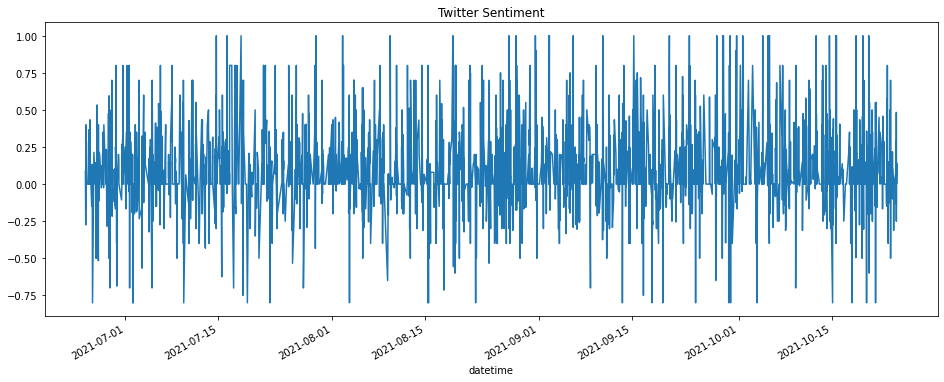

In [37]:
pdInputData.set_index("datetime").SentimentPolarity.plot(figsize = (16,6), title="Twitter Sentiment")

<AxesSubplot:xlabel='Date'>

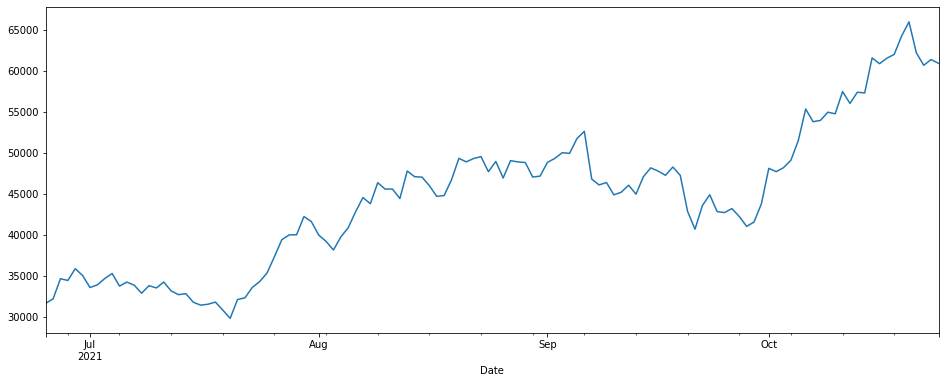

In [38]:
pdCoinMarketData.set_index('Date')['closeValue'].plot(figsize = (16,6))

Date
2021-06-25    AxesSubplot(0.125,0.125;0.775x0.755)
2021-06-26    AxesSubplot(0.125,0.125;0.775x0.755)
2021-06-27    AxesSubplot(0.125,0.125;0.775x0.755)
2021-06-28    AxesSubplot(0.125,0.125;0.775x0.755)
2021-06-29    AxesSubplot(0.125,0.125;0.775x0.755)
                              ...                 
2021-10-20    AxesSubplot(0.125,0.125;0.775x0.755)
2021-10-21    AxesSubplot(0.125,0.125;0.775x0.755)
2021-10-22    AxesSubplot(0.125,0.125;0.775x0.755)
2021-10-23    AxesSubplot(0.125,0.125;0.775x0.755)
2021-10-24    AxesSubplot(0.125,0.125;0.775x0.755)
Name: SentimentPolarity, Length: 122, dtype: object

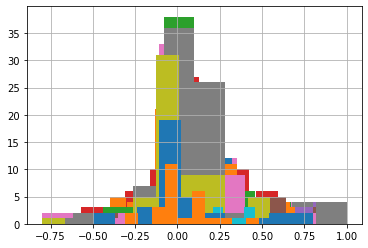

In [39]:
pdInputData.groupby("Date")['SentimentPolarity'].hist()

<AxesSubplot:title={'center':'Twitter daily Sentiment (Avg)'}, xlabel='Date'>

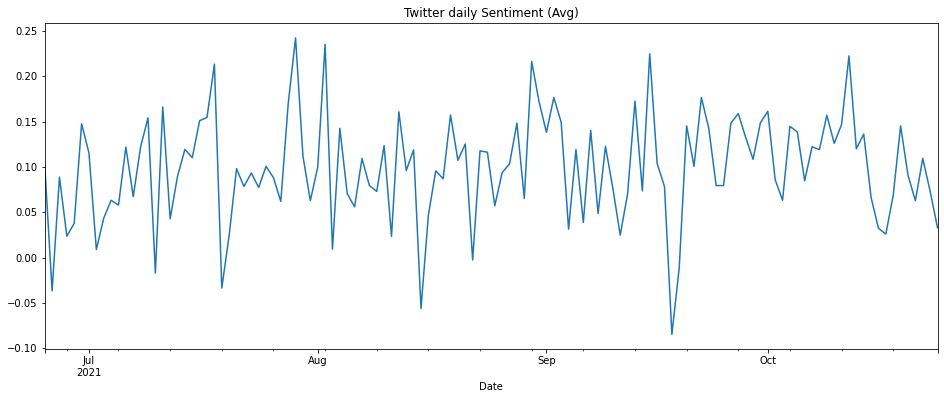

In [40]:
pdInputData.groupby("Date").mean()['SentimentPolarity'].plot(figsize = (16,6), title="Twitter daily Sentiment (Avg)")

<AxesSubplot:xlabel='Date'>

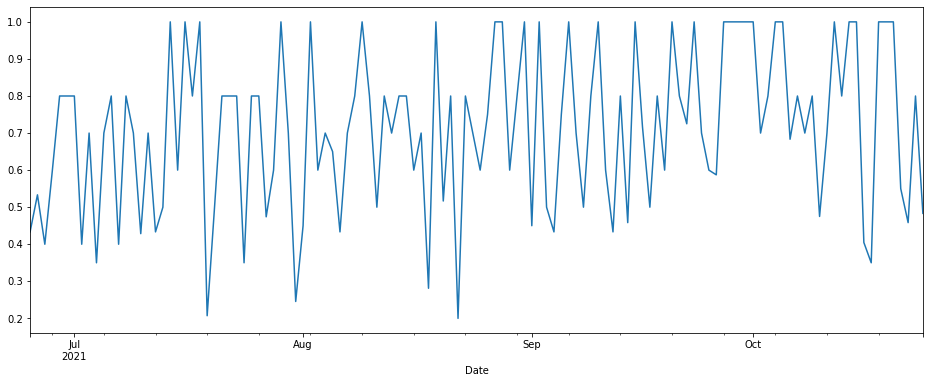

In [41]:
pdInputData.groupby("Date").max()['SentimentPolarity'].plot(figsize = (16,6))

<AxesSubplot:xlabel='Date'>

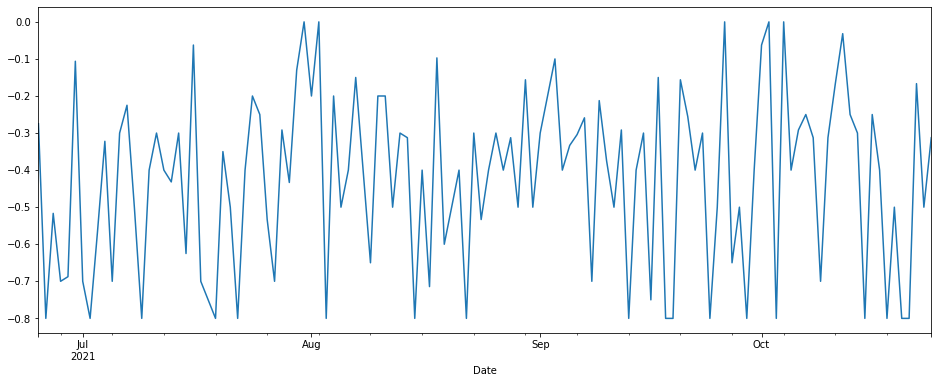

In [42]:
pdInputData.groupby("Date").min()['SentimentPolarity'].plot(figsize = (16,6))

<AxesSubplot:title={'center':'Tweeter Volume from Selected twitter accoint for BTC'}, xlabel='Date'>

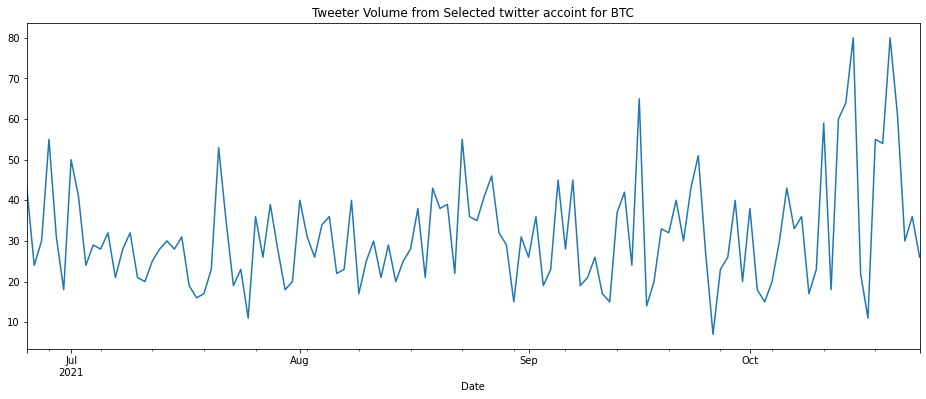

In [43]:
pdInputData.groupby("Date").count().tweet_id.plot(figsize = (16,6), title="Tweeter Volume from Selected twitter accoint for BTC")

In [44]:
pdInputData.Date.min()

Timestamp('2021-06-25 00:00:00')

#### Check any missing timeseries data in sequence

In [45]:
import pandas as pd
pdDates = DataFrame({"Date":pd.date_range(start=pdInputData.Date.min(), end=pdInputData.Date.max(), freq='1D')})
pdDates

,Date
0,2021-06-25
1,2021-06-26
2,2021-06-27
3,2021-06-28
4,2021-06-29
...,...
117,2021-10-20
118,2021-10-21
119,2021-10-22
120,2021-10-23


In [46]:
len(pdCoinMarketData)

122

In [47]:
pdInputData.drop_duplicates('Date', keep='last')[['Date']]

,Date
2734,2021-09-26
3047,2021-07-07
3178,2021-10-16
3242,2021-09-20
3258,2021-09-17
...,...
3864,2021-07-01
3865,2021-06-30
3867,2021-06-28
3869,2021-06-27


In [48]:
print("All data timeseries data is present for all the dates")
print(len(merge(pdDates,pdCoinMarketData[['Date', 'closeValue']], on='Date', how='right')) == len(pdCoinMarketData))
print(len(merge(pdDates,pdInputData.drop_duplicates('Date', keep='last'), on='Date', how='right')) == len(pdInputData.drop_duplicates('Date', keep='last')))

All data timeseries data is present for all the dates
True
True


In [49]:
pdDailyAvgSentiments.dtypes

Date                 datetime64[ns]
SentimentPolarity           float64
MinSentiment                float64
MaxSentiment                float64
TweetVolume                   int64
dtype: object

In [50]:
len(pdDailyAvgSentiments)

123

In [51]:
pdDailyAvgSentiments.head()

,Date,SentimentPolarity,MinSentiment,MaxSentiment,TweetVolume
0,2021-06-25,0.102539,-0.275000,0.433333,43
1,2021-06-26,-0.036828,-0.800000,0.533333,24
2,2021-06-27,0.088709,-0.516667,0.400000,30
3,2021-06-28,0.023519,-0.700000,0.595238,55
4,2021-06-29,0.037699,-0.687500,0.800000,31


In [52]:
pdCoinMarketData.isnull().sum()

Date          0
Open*         0
High          0
Low           0
closeValue    0
Volume        0
Market Cap    0
dtype: int64

In [53]:
pdDailyAvgSentiments=merge(pdDailyAvgSentiments, pdCoinMarketData[['Date', 'closeValue']], on='Date', how='left')

In [54]:
pdDailyAvgSentiments["BullishRatio"] = pdDailyAvgSentiments["MaxSentiment"] / pdDailyAvgSentiments["MinSentiment"]

In [55]:
pdDailyAvgSentiments.dtypes

Date                 datetime64[ns]
SentimentPolarity           float64
MinSentiment                float64
MaxSentiment                float64
TweetVolume                   int64
closeValue                  float64
BullishRatio                float64
dtype: object

In [56]:
pdDailyAvgSentiments.isnull().sum()  # We have some of the close Value as null this is not possible

Date                 0
SentimentPolarity    0
MinSentiment         0
MaxSentiment         0
TweetVolume          0
closeValue           1
BullishRatio         0
dtype: int64

In [57]:
pdDailyAvgSentiments.dropna(inplace=True)

In [58]:
pdDailyAvgSentiments.isnull().sum()  # We have some of the close Value as null this is not possible

Date                 0
SentimentPolarity    0
MinSentiment         0
MaxSentiment         0
TweetVolume          0
closeValue           0
BullishRatio         0
dtype: int64

In [59]:
pdDailyAvgSentiments.corr()

,SentimentPolarity,MinSentiment,MaxSentiment,TweetVolume,closeValue,BullishRatio
SentimentPolarity,1.000000,0.396094,0.533047,0.054700,0.051393,-0.395934
MinSentiment,0.396094,1.000000,-0.021339,-0.248187,0.091321,-0.509655
MaxSentiment,0.533047,-0.021339,1.000000,0.262527,0.160407,-0.313318
TweetVolume,0.054700,-0.248187,0.262527,1.000000,0.320174,0.089560
closeValue,0.051393,0.091321,0.160407,0.320174,1.000000,-0.099519
BullishRatio,-0.395934,-0.509655,-0.313318,0.089560,-0.099519,1.000000


# Split data into training and testing

In [60]:
def calculate_mse_rmse_acc(strModelName, y_test, y_pred):
    
    from sklearn.metrics import mean_squared_error
    
    mse = mean_squared_error(y_test, y_pred)
    print("MSE: %.2f" % mse)
    print("RMSE: %.2f" % (mse**(1/2.0)))

    # Calculate the absolute errors
    errors = abs(y_pred - y_test)
    # Determine Performance Metrics
    # Calculate mean absolute percentage error (MAPE)
    mape = 100 *  (errors /  y_test)
    # Calculate and display accuracy
    accuracy = 100 - np.mean(mape)
    print('Accuracy:', round(accuracy, 2), '%.')
    
    try:
        from sklearn.metrics import r2_score
        print("r2 score is (best is near to 1)", r2_score(y_test, y_pred))
        # R2 (coefficient of determination) regression score function.
        # Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
        # A constant model that always predicts the expected value of y, disregarding the input features, 
        # would get a  score of 0.0.
        import matplotlib.pyplot as plt
    except:
        pass
    
    try:
        print(DataFrame({"Predicted": (y_pred), 'Actual': (y_test)}).plot(figsize=(14, 5), title=f"Forecasting of BTC closing value using {strModelName}"))
        #pdResult['Predicted'] = y_pred
        #pdResult['Actual'] = y_test
        #print(pdResult[['Predicted', 'Actual']].plot(figsize=(14,5), title=f"Forecasting of BTC closing value using {strModelName}"))
        plt.show()
    except:
        pass

In [61]:
# if not installed execute following
!pip install xgboost 

In [62]:
def apply_svm_rf_xgboost(X_train,y_train, X_test,y_test):

    #Import the model we are using
    from sklearn.ensemble import RandomForestRegressor
    from sklearn import svm
    import xgboost as xgb
    
    print(" ======================== SVM ============================== ")
    
    mlSVM = svm.SVR()
    mlSVM.fit(X_train,y_train)
    y_pred_lsvm=mlSVM.predict(X_test)
    calculate_mse_rmse_acc("Linear SVM", y_test, y_pred_lsvm)
    print(" ========================= RF ============================= ")
    # Instantiate model with 1000 decision trees
    mlRF = RandomForestRegressor(n_estimators = 100, random_state = 42)
    # Train the model on training data
    mlRF.fit(X_train,y_train)
    y_pred_rf=mlRF.predict(X_test)
    # Use the forest's predict method on the test data
    calculate_mse_rmse_acc("Random Forest", y_test, y_pred_rf)
    
    print(" =========================== XGBoost =========================== ")
    #We can increase the number of iterations of the algorithm via the “n_estimators” hyperparameter that defaults to 100. Let’s increase it to 500.
    # the “eta” hyperparameter and defaults to the value of 0.3. We can try a smaller value, such as 0.05.
    #mlXgbr = xgb.XGBRegressor(n_estimators=100, eta=0.05,  subsample=0.5, colsample_bytree=0.5)
    mlXgbr = xgb.XGBRegressor(n_estimators=100, eta=0.05,  subsample=0.5, colsample_bytree=0.5)
    
    #we will try halving the number of samples and features respectively via the “subsample” and “colsample_bytree” hyperparameters.
    mlXgbr.fit(X_train,y_train)
    y_pred_xgbr=mlXgbr.predict(X_test)
    calculate_mse_rmse_acc("XGBoost", y_test, y_pred_xgbr)
    
    return y_pred_lsvm, y_pred_rf, y_pred_xgbr

In [63]:
import gc
gc.collect()

0

# Making prediction based on daily avg of Sentiments

In [64]:
len(pdDailyAvgSentiments)

122

In [65]:
pdDailyAvgSentiments

,Date,SentimentPolarity,MinSentiment,MaxSentiment,TweetVolume,closeValue,BullishRatio
0,2021-06-25,0.102539,-0.275000,0.433333,43,31637.78,-1.575758
1,2021-06-26,-0.036828,-0.800000,0.533333,24,32186.28,-0.666667
2,2021-06-27,0.088709,-0.516667,0.400000,30,34649.64,-0.774194
3,2021-06-28,0.023519,-0.700000,0.595238,55,34434.34,-0.850340
4,2021-06-29,0.037699,-0.687500,0.800000,31,35867.78,-1.163636
...,...,...,...,...,...,...,...
117,2021-10-20,0.090869,-0.800000,1.000000,80,65992.84,-1.250000
118,2021-10-21,0.062595,-0.800000,0.550000,61,62210.17,-0.687500
119,2021-10-22,0.109296,-0.166667,0.458333,30,60692.26,-2.750000
120,2021-10-23,0.073153,-0.500000,0.800000,36,61393.62,-1.600000


 ======================== SVM ============================== 
MSE: 97930140.59
RMSE: 9895.97
Accuracy: 80.43 %.
r2 score is (best is near to 1) -0.04486936014141163
AxesSubplot(0.125,0.2;0.775x0.68)


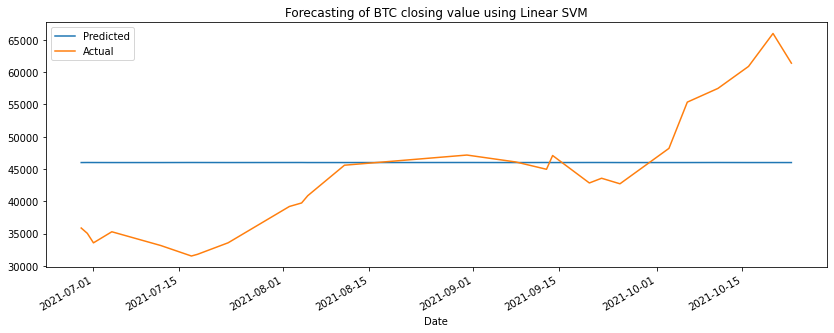

 ========================= RF ============================= 
MSE: 126682057.89
RMSE: 11255.31
Accuracy: 78.81 %.
r2 score is (best is near to 1) -0.35163903538823127
AxesSubplot(0.125,0.2;0.775x0.68)


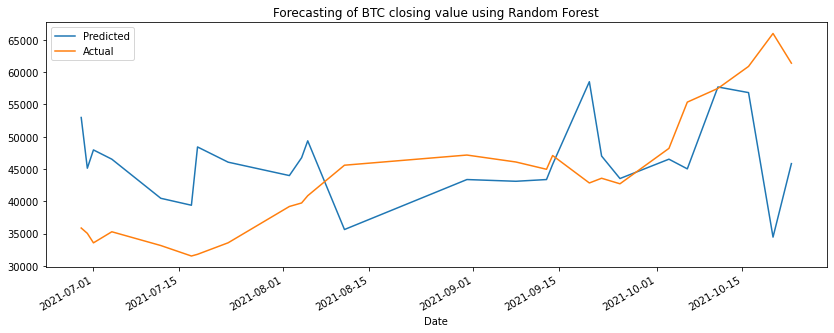

 =========================== XGBoost =========================== 
MSE: 116099683.21
RMSE: 10774.96
Accuracy: 79.62 %.
r2 score is (best is near to 1) -0.2387299861875809
AxesSubplot(0.125,0.2;0.775x0.68)


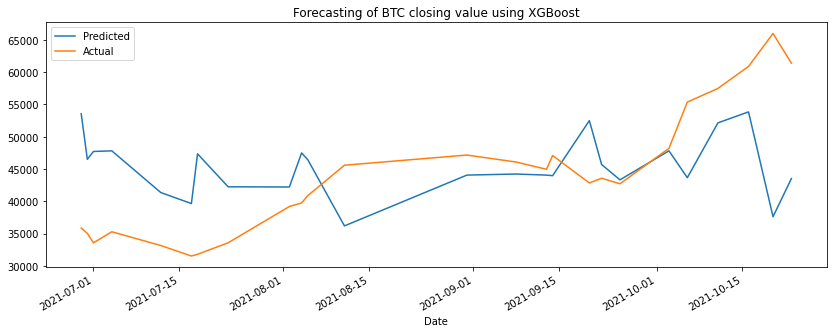

Wall time: 970 ms


In [66]:
X = pdDailyAvgSentiments.set_index('Date').tail(200)[[ 'SentimentPolarity']]
y = pdDailyAvgSentiments.set_index('Date').tail(200)['closeValue']
from sklearn.model_selection import train_test_split
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, pdDailyAvgSentiments.index, test_size=0.2, random_state=55)
%time y_pred_lsvm, y_pred_rf, y_pred_xgbr=apply_svm_rf_xgboost(X_train,y_train, X_test,y_test)

In [67]:
# Predicting close value using tweet volume

In [68]:
X = pdDailyAvgSentiments.set_index('Date').tail(200)[[ 'TweetVolume']]
y = pdDailyAvgSentiments.set_index('Date').tail(200)['closeValue']
from sklearn.model_selection import train_test_split
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, pdDailyAvgSentiments.index, test_size=0.2, random_state=55)

 ======================== SVM ============================== 
MSE: 97891261.40
RMSE: 9894.00
Accuracy: 80.44 %.
r2 score is (best is near to 1) -0.044454537147797124
AxesSubplot(0.125,0.2;0.775x0.68)


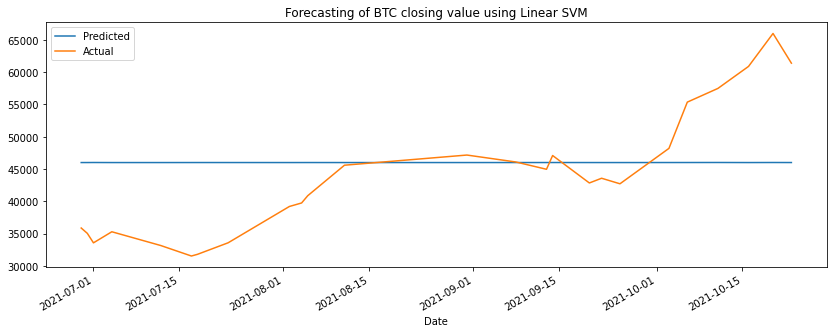

 ========================= RF ============================= 
MSE: 90250676.50
RMSE: 9500.04
Accuracy: 80.87 %.
r2 score is (best is near to 1) 0.03706697407293891
AxesSubplot(0.125,0.2;0.775x0.68)


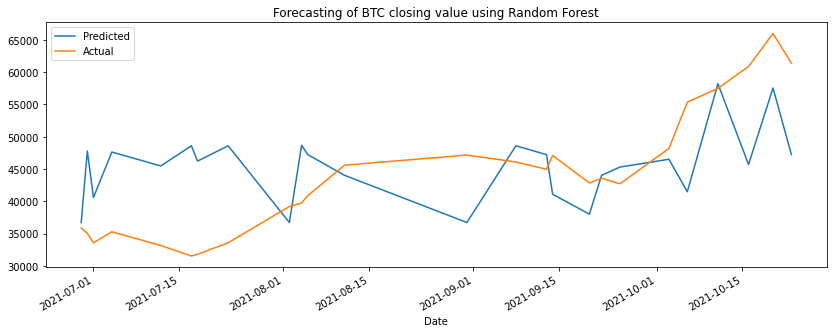

 =========================== XGBoost =========================== 
MSE: 88212666.98
RMSE: 9392.16
Accuracy: 81.64 %.
r2 score is (best is near to 1) 0.05881159422341409
AxesSubplot(0.125,0.2;0.775x0.68)


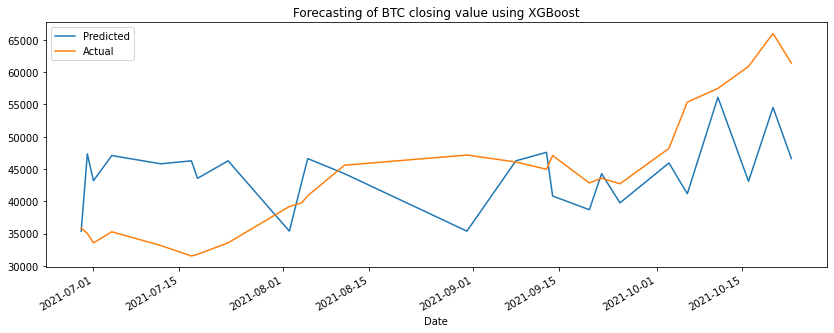

Wall time: 710 ms


In [69]:
%time y_pred_lsvm, y_pred_rf, y_pred_xgbr=apply_svm_rf_xgboost(X_train,y_train, X_test,y_test)

# 1. BERT model implementation - same day prediction

In [70]:
# if not install execute following
!pip install transformers

  Using cached huggingface_hub-0.0.12-py3-none-any.whl (37 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.2.1
    Uninstalling huggingface-hub-0.2.1:
      Successfully uninstalled huggingface-hub-0.2.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.16.1 requires huggingface-hub<1.0.0,>=0.1.0, but you have huggingface-hub 0.0.12 which is incompatible.


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output
import transformers as ppb
import warnings
import pandas
import torch
import numpy

from transformers import BertTokenizer, TFBertModel
    
def get_embedded_features_from_transformer(batch):
    # NOTE: Computational limitation on my laptop - The model throws error for chat more than 300 in length
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = TFBertModel.from_pretrained('bert-base-uncased')      # since ours is normal conversation and domain specific
    
    #tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')  # used for finanacial vocab
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer_class = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    clear_output()
    
    # -------------- Tokenising -----------------
    tokenized = batch['message'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = numpy.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = numpy.where(padded != 0, 1, 0)
    numpy.array(padded).shape

    
    # --------------- Padded ------------------
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    
    # -------- Creating last hidden states ---------
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    
    #features = last_hidden_states[0][:,0,:].numpy()
    #labels = batch['sentimentId']
    #train_features, test_features, train_labels, test_labels = train_test_split(features, labels)
    
    #return train_features, test_features, train_labels, test_labels
    
    intVocabSize=tokenizer_class.vocab_size
    
    return last_hidden_states, intVocabSize

In [72]:
#pdBert=pdInputData[['Date', 'text']]
#pdBert['text']=pdBert.text.apply(lambda x: str(x))
#pdBert=pdBert.groupby('Date').sum().reset_index()
# Experiment failed: Since keep text length below 200 or cut it if its more else model will not work will generate an error

In [73]:
pdInputData.head()

,datetime,tweet_id,text,username,LemmatizedText,SentimentPolarity,Date
0,2021-10-05 14:59:05+00:00,1445403172705607683,Legendary investor Bill Miller says “we are at...,DocumentingBTC,legendari investor bill miller say “ we top fi...,0.375000,2021-10-05
1,2021-10-05 14:57:04+00:00,1445402664049815555,US Bank to launch #Bitcoin custody services.\n...,DocumentingBTC,u bank launch bitcoin custodi servic that ’ s ...,0.214286,2021-10-05
2,2021-10-04 16:40:41+00:00,1445066353556197384,#Bitcoin is never down.\n\nhttps://t.co/5jLJsD...,DocumentingBTC,bitcoin never http co jljsdmjmj,0.000000,2021-10-04
3,2021-10-04 15:09:26+00:00,1445043389666312195,#Bitcoin 101 on ABC7 news with @natbrunell\n\n...,DocumentingBTC,bitcoin abc news natbrunel http co vuissvyz,0.000000,2021-10-04
4,2021-10-04 14:17:15+00:00,1445030259527753740,#Bitcoin Lightning growth is going vertical. h...,DocumentingBTC,bitcoin lightn growth go vertic http co quaxmagp,0.000000,2021-10-04


### Keep latest tweet of the day (only one tweet per day due to computational limitations)

In [74]:
pdBert=pdInputData[['Date', 'text', 'LemmatizedText']].drop_duplicates('Date', keep='last').reset_index()[['Date', 'text','LemmatizedText']]
#pdBert=pdInputData[['Date', 'text', 'LemmatizedText']]
print(f"Total number of training samples: {len(pdBert)}")

Total number of training samples: 122


In [75]:
# Keep latest tweet of the day (only one tweet per day due to computational limitations)
#pdBert=pdInputData[['Date', 'text']].drop_duplicates('Date', keep='last').reset_index()[['Date', 'text']]
#pdInputData["TextSize"]=pdInputData.text.apply(lambda x: len(x)) 

In [76]:
pdBert.head()

,Date,text,LemmatizedText
0,2021-09-26,My full conversation with Bitcoin Magazine's @...,full convers bitcoin magazin 's dylanleclair y...
1,2021-07-07,All the bitcoin tourists and newbies are beari...,bitcoin tourist newbi bearish everi og know bu...
2,2021-10-16,The changing of the guard.\n\n#Gold will soon ...,chang guard gold soon autocorrect bitcoin http...
3,2021-09-20,A sovereign nation state buying the #Bitcoin d...,sovereign nation state buy bitcoin dip suddenl...
4,2021-09-17,@BitcoinEcon The Bitcoin halving is nothing li...,bitcoinecon bitcoin halv noth like describ rea...


In [77]:
# get corresponding sentiment values
pdBert=merge(pdBert, pdCoinMarketData[['Date', 'closeValue']], on='Date', how='left')
pdBert.head(2)

,Date,text,LemmatizedText,closeValue
0,2021-09-26,My full conversation with Bitcoin Magazine's @...,full convers bitcoin magazin 's dylanleclair y...,43208.54
1,2021-07-07,All the bitcoin tourists and newbies are beari...,bitcoin tourist newbi bearish everi og know bu...,33855.33


In [78]:
pdBert=pdBert.set_index('Date')
batch = pdBert.tail(200).copy()

In [79]:
batch.head(2)

,text,LemmatizedText,closeValue
Date,,,
2021-09-26,My full conversation with Bitcoin Magazine's @...,full convers bitcoin magazin 's dylanleclair y...,43208.54
2021-07-07,All the bitcoin tourists and newbies are beari...,bitcoin tourist newbi bearish everi og know bu...,33855.33


In [80]:
#batch['closeValue']=round(batch['closeValue'])

<AxesSubplot:>

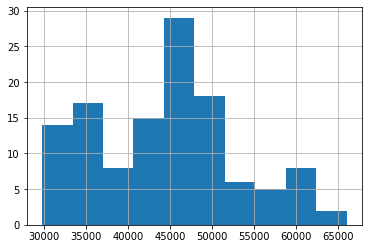

In [81]:
batch.closeValue.hist()

In [82]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from IPython.display import clear_output
import transformers as ppb
import warnings
import pandas
import torch
import numpy

from transformers import BertTokenizer, TFBertModel
intVocabSize=0
def get_embedded_features_from_transformer(batch, strTxtMessage):
    global intVocabSize
    # NOTE: Computational limitation on my laptop - The model throws error for chat more than 300 in length
    tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')# finance based
    model = TFBertModel.from_pretrained('bert-base-uncased')      
    
    #tokenizer = BertTokenizer.from_pretrained('ProsusAI/finbert')  # used for finanacial vocab
    model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
    tokenizer_class = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    clear_output()
    
    # -------------- Tokenising -----------------
    tokenized = batch[strTxtMessage].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

    max_len = 0
    for i in tokenized.values:
        if len(i) > max_len:
            max_len = len(i)

    padded = numpy.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
    attention_mask = numpy.where(padded != 0, 1, 0)
    numpy.array(padded).shape

    
    # --------------- Padded ------------------
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)
    
    # -------- Creating last hidden states ---------
    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
        
    intVocabSize=tokenizer_class.vocab_size
    
    del(model)
    del(tokenizer)
    del(model_class)
    del(tokenizer_class)
    del(pretrained_weights)
    
    print(f"Vocabulary size:{intVocabSize}")

    return last_hidden_states

In [83]:
def split_data_into_training_testing(last_hidden_states, batch):
    features = last_hidden_states[0][:,0,:].numpy()
    labels = batch['closeValue']
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels,\
                                                                                train_size=0.8, random_state = 0)
    return train_features, test_features, train_labels, test_labels

In [84]:
gc.collect()

19062

<AxesSubplot:xlabel='Date'>

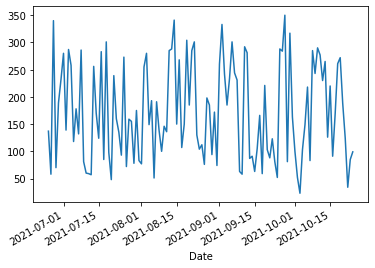

In [85]:
batch.text.apply(lambda x: len(x)).plot()

<AxesSubplot:xlabel='Date'>

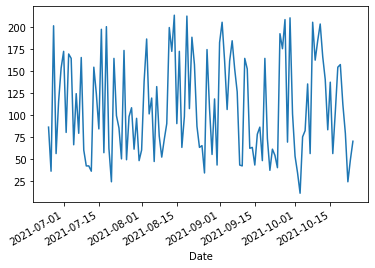

In [86]:
batch.LemmatizedText.apply(lambda x: len(x)).plot()

#### Experiment 1: Using normal text

In [87]:
#For training and testing development 
train_features, test_features, train_labels, test_labels=split_data_into_training_testing(get_embedded_features_from_transformer(batch, 'text') , batch)

Vocabulary size:30522


 ======================== SVM ============================== 
MSE: 85254834.96
RMSE: 9233.35
Accuracy: 83.85 %.
r2 score is (best is near to 1) -0.03013293229995062
AxesSubplot(0.125,0.2;0.775x0.68)


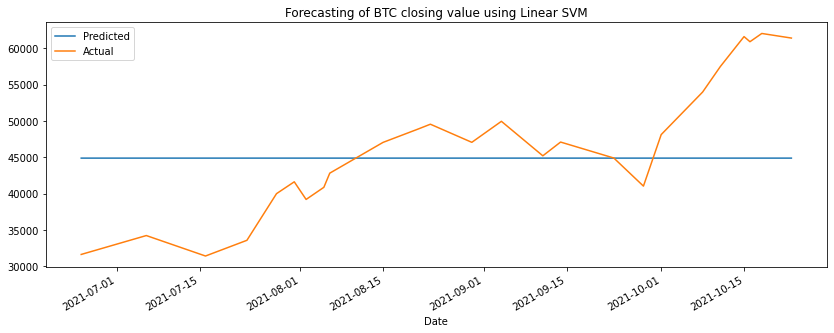

 ========================= RF ============================= 
MSE: 89694835.36
RMSE: 9470.74
Accuracy: 83.84 %.
r2 score is (best is near to 1) -0.08378139251509076
AxesSubplot(0.125,0.2;0.775x0.68)


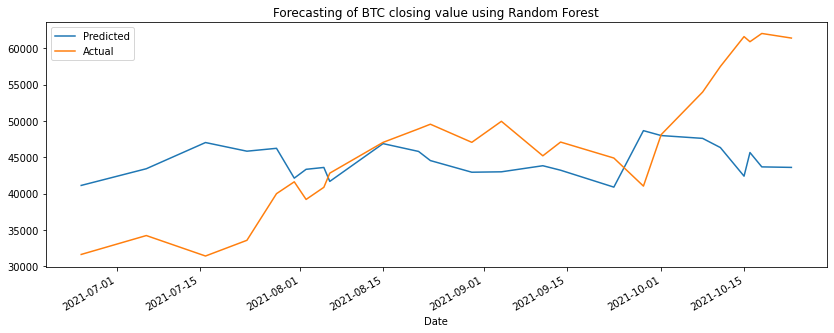

 =========================== XGBoost =========================== 
MSE: 105319312.41
RMSE: 10262.52
Accuracy: 81.89 %.
r2 score is (best is near to 1) -0.27257172179582767
AxesSubplot(0.125,0.2;0.775x0.68)


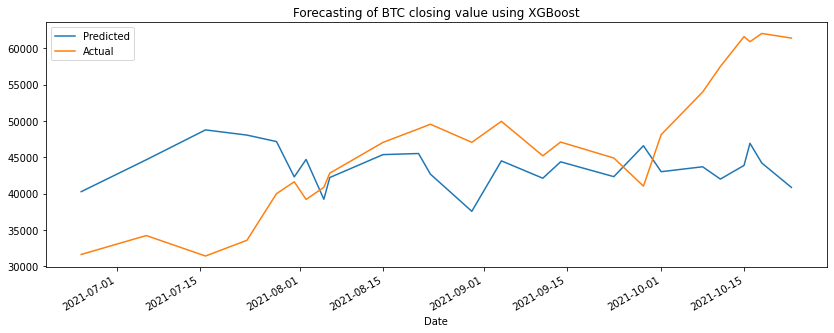

Wall time: 2.14 s


In [88]:
#apply_svm_rf_xgboost(X_train,y_train, X_test,y_test)
%time y_pred_lsvm, y_pred_rf, y_pred_xgbr=apply_svm_rf_xgboost(train_features,train_labels, test_features,test_labels)

#### Experiment 2: Using normal pre-processed text

Vocabulary size:30522
 ======================== SVM ============================== 
MSE: 85254369.89
RMSE: 9233.33
Accuracy: 83.85 %.
r2 score is (best is near to 1) -0.03012731282125225
AxesSubplot(0.125,0.2;0.775x0.68)


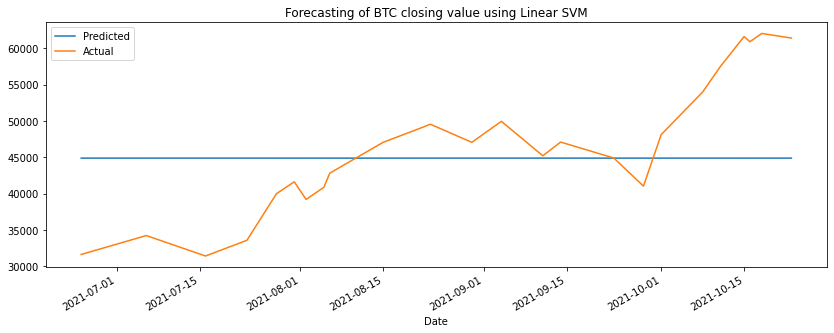

 ========================= RF ============================= 
MSE: 96813938.99
RMSE: 9839.41
Accuracy: 84.57 %.
r2 score is (best is near to 1) -0.16980141835875995
AxesSubplot(0.125,0.2;0.775x0.68)


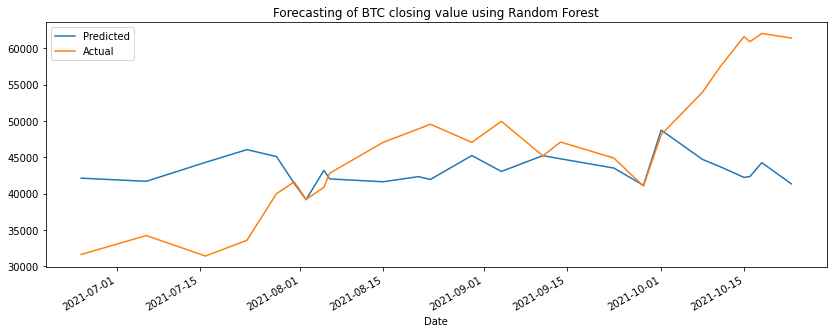

 =========================== XGBoost =========================== 
MSE: 123435773.52
RMSE: 11110.17
Accuracy: 82.23 %.
r2 score is (best is near to 1) -0.4914726582151814
AxesSubplot(0.125,0.2;0.775x0.68)


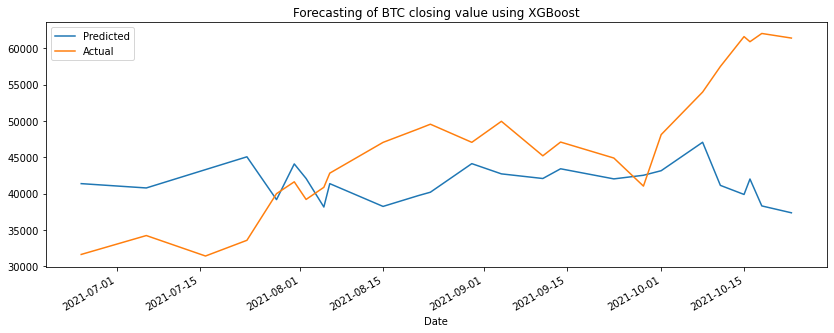

Wall time: 2.28 s


In [89]:
# pre processed 
train_features, test_features, train_labels, test_labels=split_data_into_training_testing(get_embedded_features_from_transformer(batch, 'LemmatizedText'), batch)
#apply_svm_rf_xgboost(X_train,y_train, X_test,y_test)
%time y_pred_lsvm, y_pred_rf, y_pred_xgbr=apply_svm_rf_xgboost(train_features,train_labels, test_features,test_labels)

In [90]:
del(pdBert)
del(batch)
gc.collect()

18663

### OBSERVATION:
- After prprocessed data to the bert we were able to get good score

# Lexis Nexis Data for the Prediction

In [99]:
pdLexisNexis = read_csv('lexisnexis_raw.csv')
pdLexisNexis['Date'] = to_datetime(pdLexisNexis['dates']).dt.date
pdLexisNexis['Date']= to_datetime(pdLexisNexis['Date'])

In [100]:
%time pdLexisNexis['LemmatizedText'] = pdLexisNexis['titles'].apply(preprocessDataset)

Wall time: 36.4 s


In [101]:
pdLexisNexis.head()

,dates,titles,Date,LemmatizedText
0,"Oct 24, 2021",NewsWatch: Big Tech stocks are the market's su...,2021-10-24,newswatch big tech stock market 's superstar r...
1,"Oct 24, 2021",bZx Protocol (BZRX) Price Hits $0.33 on Top Ex...,2021-10-24,bzx protocol bzrx price hit top exchang
2,"Oct 24, 2021",bZx Protocol Price Reaches $0.33 on Exchanges ...,2021-10-24,bzx protocol price reach exchang bzrx
3,"Oct 23, 2021",Inside the Courts - An Update From Skadden Sec...,2021-10-23,insid court updat skadden secur litig octob
4,"Oct 23, 2021",What's The Deal With Well Everything?!!,2021-10-23,what 's deal well everyth


In [102]:
pdLexisNexis.dtypes

dates                     object
titles                    object
Date              datetime64[ns]
LemmatizedText            object
dtype: object

<AxesSubplot:>

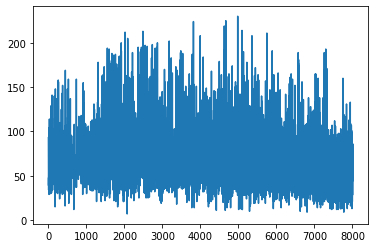

In [103]:
pdLexisNexis.titles.apply(lambda x: len(x)).plot()

In [104]:
pdLexisNexis=pdLexisNexis[pdLexisNexis.Date >= pdDailyAvgSentiments.Date.min()]
pdLexisNexis=pdLexisNexis[pdLexisNexis.Date <= pdDailyAvgSentiments.Date.max()]

# Keep latest twitter data upto dates to which we have coinmarket data with us
#pdInputData=pdInputData[pdInputData.Date <= pdCoinMarketData.Date.max()]

#print(f"Twitter Data is from:{pdInputData.Date.min()} to {pdInputData.Date.max()}, total={intTotalTwitts}")
print(f"pdLexisNexis Data is from:{pdLexisNexis.Date.min()} to {pdLexisNexis.Date.max()}, total={len(pdLexisNexis)}")

pdLexisNexis Data is from:2021-06-25 00:00:00 to 2021-10-24 00:00:00, total=1353


In [105]:
pdLexisNexis=merge(pdLexisNexis[['Date', 'titles', 'LemmatizedText']],pdCoinMarketData[['Date', 'closeValue']], on='Date', how='left')

In [106]:
pdLexisNexis=pdLexisNexis.set_index('Date')

In [187]:
pdLexisNexis.head(2)

,titles,LemmatizedText,closeValue
Date,,,
2021-10-24,NewsWatch: Big Tech stocks are the market's su...,newswatch big tech stock market 's superstar r...,60930.84
2021-10-24,bZx Protocol (BZRX) Price Hits $0.33 on Top Ex...,bzx protocol bzrx price hit top exchang,60930.84


Vocabulary size:30522
Wall time: 6.16 s
 ======================== SVM ============================== 
MSE: 962991.85
RMSE: 981.32
Accuracy: 97.66 %.
r2 score is (best is near to 1) -0.013947981642019602
AxesSubplot(0.125,0.2;0.775x0.68)


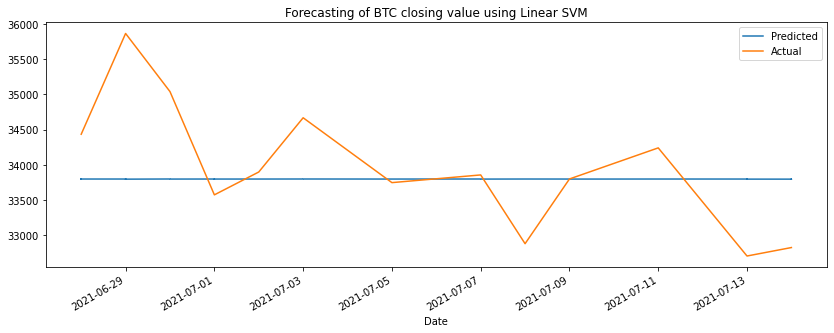

 ========================= RF ============================= 
MSE: 937996.61
RMSE: 968.50
Accuracy: 97.74 %.
r2 score is (best is near to 1) 0.012369875973346267
AxesSubplot(0.125,0.2;0.775x0.68)


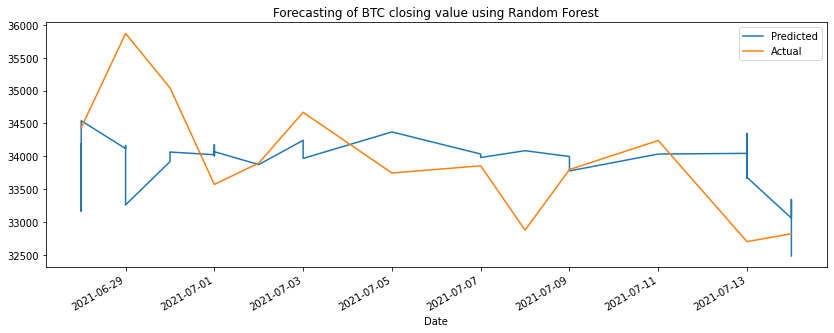

 =========================== XGBoost =========================== 
MSE: 1391280.25
RMSE: 1179.53
Accuracy: 97.3 %.
r2 score is (best is near to 1) -0.4648989976177036
AxesSubplot(0.125,0.2;0.775x0.68)


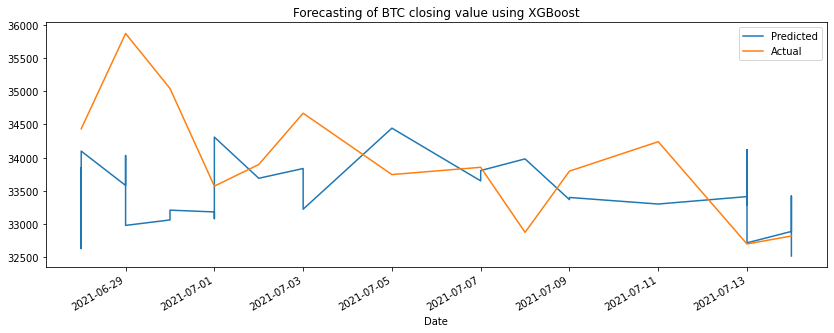

Wall time: 3.13 s


In [108]:
batch=pdLexisNexis[['titles', 'closeValue']].tail(200).copy()
# normal text
%time train_features, test_features, train_labels, test_labels=split_data_into_training_testing(get_embedded_features_from_transformer(batch, 'titles'), batch)
%time y_pred_lsvm, y_pred_rf, y_pred_xgbr=apply_svm_rf_xgboost(train_features,train_labels, test_features,test_labels)

In [109]:
### pre processed 
batch=pdLexisNexis[['LemmatizedText', 'closeValue']].tail(200).copy()
%time train_features, test_features, train_labels, test_labels=split_data_into_training_testing(get_embedded_features_from_transformer(batch, 'LemmatizedText'), batch)

Vocabulary size:30522
Wall time: 6.03 s


 ======================== SVM ============================== 
MSE: 963053.07
RMSE: 981.35
Accuracy: 97.66 %.
r2 score is (best is near to 1) -0.014012432515081663
AxesSubplot(0.125,0.2;0.775x0.68)


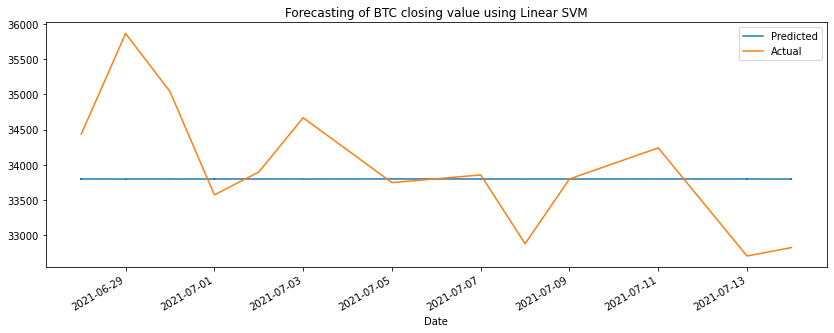

 ========================= RF ============================= 
MSE: 1245579.49
RMSE: 1116.06
Accuracy: 97.34 %.
r2 score is (best is near to 1) -0.3114885742903253
AxesSubplot(0.125,0.2;0.775x0.68)


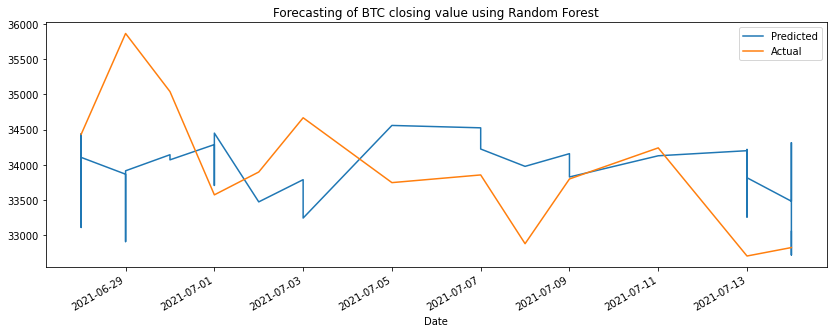

 =========================== XGBoost =========================== 
MSE: 1384240.55
RMSE: 1176.54
Accuracy: 97.39 %.
r2 score is (best is near to 1) -0.4574867933288611
AxesSubplot(0.125,0.2;0.775x0.68)


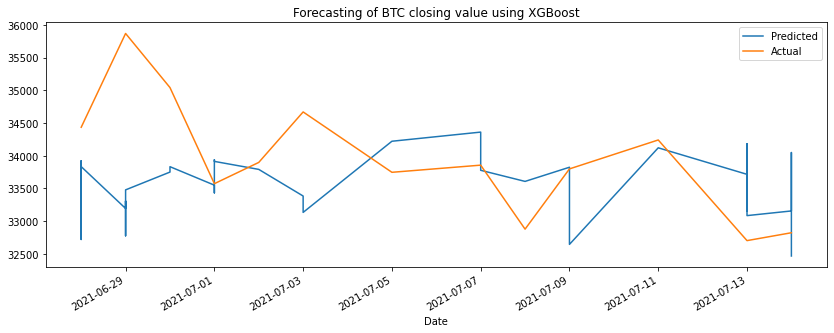

Wall time: 3.03 s


In [110]:
%time y_pred_lsvm, y_pred_rf, y_pred_xgbr=apply_svm_rf_xgboost(train_features,train_labels, test_features,test_labels)